In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow.compat.v2.feature_column as fc
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import matplotlib.pyplot as plt
from six.moves import urllib
from scipy.io import arff
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
data_train_20 = arff.loadarff('KDDTrain+_20Percent_fixed.arff')
df_train_20 = pd.DataFrame(data_train_20[0])
# data_train = arff.loadarff('KDDTrain+_fixed.arff')
# df_train = pd.DataFrame(data_train[0])
data_test = arff.loadarff('KDDTest+_fixed.arff')
df_test = pd.DataFrame(data_test[0])

In [ ]:
df_train_20.head()

In [ ]:
# le = LabelEncoder()
# for col, vals in df_train_20[['class','protocol_type','service','flag','land','logged_in','is_host_login','is_guest_login']].items():
# #     print(df_train_20[col])
# #     if df_train_20[col] in CATEGORICAL_COLUMNS:
#     label = le.fit_transform(df_train_20[col])
#     df_train_20.drop(col, axis=1, inplace=True)
#     df_train_20[col] = label
# df_train_20.head()

In [ ]:
# for col, vals in df_test[['class','protocol_type','service','flag','land','logged_in','is_host_login','is_guest_login']].items():
# #     print(df_train_20[col])
# #     if df_train_20[col] in CATEGORICAL_COLUMNS:
#     label = le.fit_transform(df_test[col])
#     df_test.drop(col, axis=1, inplace=True)
#     df_test[col] = label
# df_test.head()

In [3]:
le = LabelEncoder()
label = le.fit_transform(df_train_20['class'])
df_train_20.drop('class', axis=1, inplace=True)
df_train_20['class'] = label
df_train_20.head()

label = le.fit_transform(df_test['class'])
df_test.drop('class', axis=1, inplace=True)
df_test['class'] = label

In [4]:
y_train_20 = df_train_20.pop('class') # anomaly vs. normal
y_test = df_test.pop('class')

In [5]:
CATEGORICAL_COLUMNS = ['protocol_type',
                       'service',
                       'flag',
                       'land',
                       'logged_in',
                       'is_host_login',
                       'is_guest_login']

NUMERIC_COLUMNS = ['duration',
                   'src_bytes',
                   'dst_bytes',
                   'wrong_fragment',
                   'urgent',
                   'hot',
                   'num_failed_logins',
                   'num_compromised',
                   'root_shell',
                   'su_attempted',
                   'num_root',
                   'num_file_creations',
                   'num_shells',
                   'num_access_files',
                   'num_outbound_cmds',
                   'count',
                   'srv_count',
                   'serror_rate',
                   'srv_serror_rate',
                   'rerror_rate',
                   'srv_rerror_rate',
                   'same_srv_rate',
                   'diff_srv_rate',
                   'srv_diff_host_rate',
                   'dst_host_count',
                   'dst_host_srv_count',
                   'dst_host_same_srv_rate',
                   'dst_host_diff_srv_rate',
                   'dst_host_same_src_port_rate',
                   'dst_host_srv_diff_host_rate',
                   'dst_host_serror_rate',
                   'dst_host_srv_serror_rate',
                   'dst_host_rerror_rate',
                   'dst_host_srv_rerror_rate']
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = df_train_20[feature_name].unique()  # gets a list of all unique values from given feature column
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='protocol_type', vocabulary_list=(b'tcp', b'udp', b'icmp'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='service', vocabulary_list=(b'ftp_data', b'other', b'private', b'http', b'remote_job', b'name', b'netbios_ns', b'eco_i', b'mtp', b'telnet', b'finger', b'domain_u', b'supdup', b'uucp_path', b'Z39_50', b'smtp', b'csnet_ns', b'uucp', b'netbios_dgm', b'urp_i', b'auth', b'domain', b'ftp', b'bgp', b'ldap', b'ecr_i', b'gopher', b'vmnet', b'systat', b'http_443', b'efs', b'whois', b'imap4', b'iso_tsap', b'echo', b'klogin', b'link', b'sunrpc', b'login', b'kshell', b'sql_net', b'time', b'hostnames', b'exec', b'ntp_u', b'discard', b'nntp', b'courier', b'ctf', b'ssh', b'daytime', b'shell', b'netstat', b'pop_3', b'nnsp', b'IRC', b'pop_2', b'printer', b'tim_i', b'pm_dump', b'red_i', b'netbios_ssn', b'rje', b'X11', b'urh_i', b'http_8001'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoric

In [6]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=1000):
    def input_function():  # inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
        if shuffle:
            ds = ds.shuffle(1000)  # randomize order of data
        ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
        return ds  # return a batch of the dataset
    return input_function  # return a function object for use

train_20_input_fn = make_input_fn(df_train_20, y_train_20)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
test_input_fn = make_input_fn(df_test, y_test, num_epochs=1, shuffle=False)

In [7]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8et1bqlj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
linear_est.train(train_20_input_fn)  # train

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp8et1bqlj/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931475, step = 0
INFO:tensorflow:global_step/sec: 17.5
INFO:tensorflow:loss = 61.541348, step = 100 (5.717 sec)
INFO:tensorflow:global_step/sec: 19.7667
INFO:tensorflow:loss = 10.483641, step = 200 (5.059 sec)
INFO:tensorflow:Calling checkpoint

In [9]:
result = linear_est.evaluate(test_input_fn)  # get model metrics/stats by testing on tetsing data

# clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-10-25T22:51:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8et1bqlj/model.ckpt-260
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 2.99364s
INFO:tensorflow:Finished evaluation at 2022-10-25-22:51:53
INFO:tensorflow:Saving dict for global step 260: accuracy = 0.60783356, accuracy_baseline = 0.56924236, auc = 0.60970616, auc_precision_recall = 0.5169946, average_loss = 162.2447, global_step = 260, label/mean = 0.43075764, loss = 163.66975, precision = 0.540677, prediction/mean = 0.474404, recall = 0.59540725
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 260: /tmp/tmp8et1bqlj/model.ckpt-260
0.60783356


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8et1bqlj/model.ckpt-260
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<IPython.core.display.Javascript object>


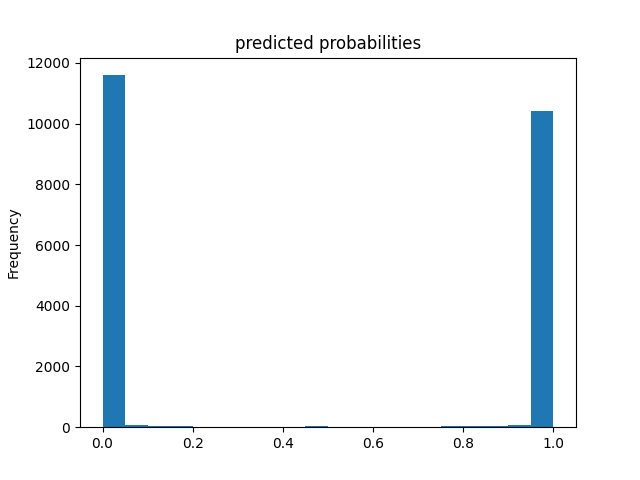

<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

In [13]:
pred_dicts = list(linear_est.predict(test_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [12]:
from importlib import reload
reload(plt)
%matplotlib notebook